# Interpolate weather data from the BOM (Bureau of Meteorology) via requests to the v1 Weather API

#### 1) Import modules required

In [91]:
import json
import urllib 
import json
import datetime
import numpy as np
from scipy.interpolate import Rbf, griddata, interp2d, NearestNDInterpolator, LinearNDInterpolator
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import interpolate
%matplotlib inline  

import sys
import requests


#### 2) Set Global variables (api_url, places), getJson requests function

In [66]:
### Global Vars:
api_url="https://api.weather.bom.gov.au/v1/locations"

## commonly used functions
def getJson(url):

    try:  
        req=requests.get(url)        
        if req.status_code == 200:
            json=req.json()
            return json
        else:
            print('Could not fetch request, status code was {0}'.format(req.status_code))
            return None
    except:
        print('Coult not fetch a request')


    

places=["Melbourne(OlympicPark)","MelbourneAirport","AvalonAirport", "Cerberus",
        "Coldstream", "EssendonAirport", "FawknerBeacon","FernyCreek","Frankston",
        "GeelongRacecourse","Laverton","Moorabbin Airport","Rhyll","Scoresby","Sheoaks",
        "SouthChannelIsland","StKildaHarbour","Viewbank"]


#### 3) Functions for getting location data from string text place names, and querying observation values

In [245]:
def get_geohash(location):
#
#   Get the 'geohash' from the bom api.
#   geohash for a location is needed to query more location information (e.g. lat/lon) and observations
#   
#   Usage:
#   geohash=get_geohash(location) 

#   Inputs:
#   location - string text of a placename, this is fixed to search place names in Victoria, Australia
#   
    url="{0}/?search={1}&VIC".format(api_url,location)
    jsonData=getJson(url)
   # there may be more than one data item returned but we are just going to grab the first if exists:
    geohash=jsonData['data'][0]['geohash']

    return geohash


def get_latlong(geohash): 
#
#   Get the latitude/longitude  from the bom api for a geohash matched place name
#   Geohash for a location is needed to query more location information (e.g. lat/lon) and observations
#   
#   Usage:
#   geohash=get_geohash(location) 

#   Inputs:
#   location - string text of a placename, this is fixed to search place names in Victoria, Australia
#       
    url="{0}/{1}".format(api_url,geohash[0:6])
    jsonData=getJson(url)

    lat = jsonData['data']['latitude']
    lon = jsonData['data']['longitude']

    return lat,lon   


def get_observation(geohash,observable):  
#
#   Get the observed metric (e.g. temp, apparent_temp, rainfall) from the bom api.
   
#   Usage:
#   observation=get_observations(geohash,observable) 

#    Inputs:
#   geohash  - is the retrieved geohash identifier for a location
#   observable - is the measured weather variable - string - options include:
#    'temp','temp_feels_like','rain_since_9am','humidity'
#
    url="{0}/{1}/observations".format(api_url,geohash[0:6])

    jsonData=getJson(url)
    obs = jsonData['data'][observable]

    return obs

# Test The above functions
    
geohash = get_geohash('Viewbank')
temp=get_observations(geohash,'temp')

print(geohash)
print(temp)

r1r1m9t
13.6


#### Interpolation Functions

In [289]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T
    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi):
    # this comes from stack exchange - 
    # https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python
    dist = distance_matrix(x,y, xi,yi)
    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def get_meshgrid(x,y,z,gridsize,interp_type):
#   Calculate interpolated grid of values for input x,y points and z observations
#   
#    Inputs:
#    x: x value of location
#    y: y value of location
#    z: observed values at the x,y pairs
#    gridsize: integer for number linearly spaced points in new x,y grid
#    interp_type: see class reference from scipy https://docs.scipy.org/doc/scipy/tutorial/interpolate.html
#    Current implemented options are :
#               '   rbf' (radial basis function),
#                  'linearND' (LinearND Interpolator),
#                  'nearest' (Nearest ND Interpolator)
    LONG_LIMITS=[float(min(y)), float(max(y))]
    LAT_LIMITS=[float(min(x)),float(max(x))]

    XI, YI = np.meshgrid(
        np.linspace(LAT_LIMITS[0], LAT_LIMITS[1], gridsize),
        np.linspace(LONG_LIMITS[0], LONG_LIMITS[1], gridsize)
        )
    if interp_type == 'rbf':
        interp_values = Rbf(x, y, z, method='cubic')
        ZI = interp_values(XI, YI)
    elif interp_type == 'linearND':
        interp_values = LinearNDInterpolator(list(zip(x, y)), z)
        ZI = interp_values(XI, YI)
    elif interp_type == 'nearest':
        interp_values = NearestNDInterpolator(list(zip(x,y)),z)
        ZI = interp_values(XI,YI)
       
    return (XI, YI, ZI) 


#### 4) Populate lists of locations and temperatures 

In [290]:
temps=[]
latlongs=[]
x=[]
y=[]

for place in places:
    geohash=get_geohash(place)
    geohashes.append(geohash)

geohashset = list(set(geohashes))


## Skipping fetching locations for now - have a bunch of geohashes for quicktest
#geohashes = ['r1r1m9t', 'r1nwvj5', 'r1r0fup', 'r6ks539', 'r1n5t2b', 'r3319cv', 'r32x01v'];

for geohash in geohashset:
    #1geohash=get_geohash(place)
    lat,lon=get_latlong(geohash)
    latlongs.append([lat,lon])
    x.append(lat)
    y.append(lon)
    obs=get_observations(geohash,'temp')
    
    temps.append(obs)

print(temps)
print(latlongs)  

[11.7, 12.9, 14.8, 12.4, 17.7, 13.8, 14.7]
[[-38.75701904296875, 143.6737060546875], [-37.74078369140625, 145.0909423828125], [-36.73004150390625, 146.9586181640625], [-37.69683837890625, 147.7386474609375], [-31.63238525390625, 152.7264404296875], [-37.81219482421875, 144.9700927734375], [-38.15826416015625, 144.3658447265625]]


### In case any observed values are null, do this:

In [219]:
## If one of the fetched temperatures is None/Null replace with the average
ave=sum(temps)/len(temps)
print(ave)
t=[ave if v == None else v for v in temps] # now replace the Nones with the average value

print(t)
# looking at solution here --https://stackoverflow.com/questions/37662180/interpolate-missing-values-2d-python?noredirect=1&lq=1

11.9
[11.7, 10.2, 10.1, 9.7, 16.9, 11.6, 13.1]


In [291]:
#### Print out the grid values
print(x)
print(y)

[-38.75701904296875, -37.74078369140625, -36.73004150390625, -37.69683837890625, -31.63238525390625, -37.81219482421875, -38.15826416015625]
[143.6737060546875, 145.0909423828125, 146.9586181640625, 147.7386474609375, 152.7264404296875, 144.9700927734375, 144.3658447265625]


#### 5) Calculated interpolated values on grid

In [292]:
# 'interp_type' options
#               '   rbf' (radial basis function),
#                  'linearND' (LinearND Interpolator),
#                  'nearest' (Nearest ND Interpolator)
(XI,YI,ZI)=get_meshgrid(x,y,temps,20,'linearND')
(XI,YI,Z2) =get_meshgrid(x,y,temps,20,'nearest')
(XI, YI,Z3) = get_meshgrid(x,y,temps,20,'rbf')

# CALC IDW TOO
xi, yi = XI.flatten(), YI.flatten()
Z4 = simple_idw(x,y,temps,xi,yi)
Z4 = Z4.reshape(20, 20)





/tmp/ipykernel_107/1517195224.py:17: RuntimeWarning: divide by zero encountered in divide
  weights = 1.0 / dist
/tmp/ipykernel_107/1517195224.py:20: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=0)


#### 6) Plot the different interpolations of the temperature values

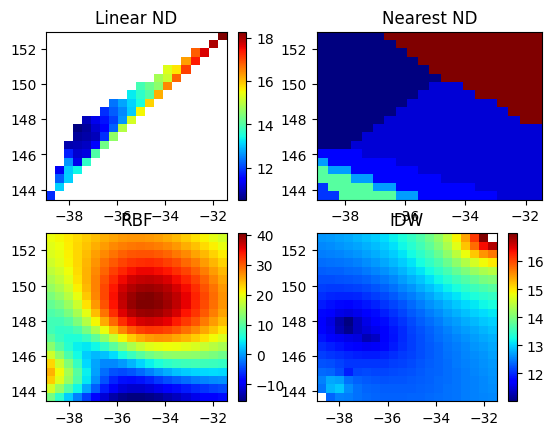

In [287]:
fig, axes = plt.subplots(nrows=2, ncols=2)


plt.subplot(2, 2, 1)
plt.title('Linear ND')
plt.pcolormesh(XI,YI,ZI,cmap='jet')


plt.subplot(2, 2, 2)
plt.title('Nearest ND')
plt.colorbar()
plt.pcolormesh(XI, YI, Z2,cmap='jet')

plt.subplot(2, 2, 3)
plt.title('RBF')
plt.pcolormesh(XI, YI, Z3,cmap='jet')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('IDW')

plt.pcolormesh(XI, YI,Z4,cmap='jet')
plt.colorbar()

plt.show()

#plt.scatter(x,y,100,temps,cmap='jet')

#plt.axis("equal")
#$plot_title='{0} Interpolation '.format(interp_type)
#plt.title(plot_title)
#plt.show()